In [129]:
# Import required libraries
import os
from pyrocko import gf, trace, io
from pyrocko.gf import DCSource, MTSource
from pyrocko import model
import matplotlib.pyplot as plt
import numpy as np
from obspy import read_inventory
from datetime import datetime

## 1. Define the Earthquake Source from AFAD Data

In [130]:
# Event parameters from AFAD
event_lat = 40.8558
event_lon = 28.4311
event_depth = 10000.0  # meters (adjusted to 10 km - max depth in GF store)
event_time = '2025-04-25 17:33:15'

# NOTE: Original depth was 11 km, but Green's function store only covers 5-10 km
# We use 10 km as the closest valid depth

# Option 1: Using Double-Couple source (NP1)
source_dc = DCSource(
    lat=event_lat,
    lon=event_lon,
    depth=event_depth,
    strike=168.0,
    dip=47.0,
    rake=-37.0,
    magnitude=4.2,
    time=0.0
)

# Option 2: Using Full Moment Tensor
source_mt = MTSource(
    lat=event_lat,
    lon=event_lon,
    depth=event_depth,
    mnn=-0.151e16,   # Mrr
    mee=-0.096e16,   # Mtt  
    mdd=-0.081e16,   # Mpp
    mne=0.049e16,    # Mrt
    mnd=0.028e16,    # Mrp
    med=-0.030e16,   # Mtp
    time=0.0
)

# We'll use the Double-Couple source for simplicity
source = source_dc
print(f"Source configured: Mw {source.magnitude}, Depth={source.depth/1000:.1f} km")
print(f"Strike={source.strike}°, Dip={source.dip}°, Rake={source.rake}°")

Source configured: Mw 4.2, Depth=10.0 km
Strike=168.0°, Dip=47.0°, Rake=-37.0°


## 2. Load Station Information

In [131]:
# Load station metadata from StationXML files
station_dir = '20250425/stations'
station_files = [f for f in os.listdir(station_dir) if f.endswith('.xml')]

stations = []
for station_file in sorted(station_files):
    try:
        inv = read_inventory(os.path.join(station_dir, station_file))
        for network in inv:
            for station in network:
                stations.append({
                    'network': network.code,
                    'station': station.code,
                    'lat': station.latitude,
                    'lon': station.longitude,
                    'elevation': station.elevation
                })
    except Exception as e:
        print(f"Warning: Could not read {station_file}: {e}")

print(f"Loaded {len(stations)} stations:")
for st in stations[:5]:  # Show first 5
    print(f"  {st['network']}.{st['station']}: {st['lat']:.4f}°N, {st['lon']:.4f}°E")

Loaded 19 stations:
  KO.BGKT: 41.1810°N, 28.7730°E
  KO.BOTS: 40.9902°N, 27.9810°E
  KO.BRGA: 40.8846°N, 29.0650°E
  KO.BUYA: 40.8694°N, 29.1278°E
  KO.CRLU: 41.1428°N, 27.8215°E


## 3. Set Up Green's Function Engine and Targets

In [132]:
# Initialize the Green's function engine
store_id = 'marmara_gfs'
engine = gf.LocalEngine(store_superdirs=['.'])

# Get the GF store to check its distance constraints
store = engine.get_store(store_id)
print(f"GF Store constraints:")
print(f"  Source depth range: {store.config.source_depth_min/1000:.1f} - {store.config.source_depth_max/1000:.1f} km")
print(f"  Distance range: {store.config.distance_min/1000:.1f} - {store.config.distance_max/1000:.1f} km")

# Filter stations by distance from source
from pyrocko.orthodrome import distance_accurate50m

valid_stations = []
for st in stations:
    dist = distance_accurate50m(event_lat, event_lon, float(st['lat']), float(st['lon']))
    if store.config.distance_min <= dist <= store.config.distance_max:
        valid_stations.append(st)
        print(f"  ✓ {st['network']}.{st['station']}: {dist/1000:.1f} km")
    else:
        print(f"  ✗ {st['network']}.{st['station']}: {dist/1000:.1f} km (out of range)")

print(f"\nUsing {len(valid_stations)} of {len(stations)} stations within valid distance range")

# Create targets for valid stations only (3 components)
targets = []
components = ['Z', 'N', 'E']  # Vertical, North, East

for st in valid_stations:
    for comp in components:
        target = gf.Target(
            codes=(st['network'], st['station'], '', f'HH{comp}'),
            lat=float(st['lat']),  # Convert to Python float
            lon=float(st['lon']),  # Convert to Python float
            store_id=store_id,
            quantity='displacement'  # or 'velocity'
        )
        targets.append(target)

print(f"Created {len(targets)} targets ({len(valid_stations)} stations × {len(components)} components)")

GF Store constraints:
  Source depth range: 5.0 - 10.0 km
  Distance range: 20.0 - 80.0 km
  ✓ KO.BGKT: 46.2 km
  ✓ KO.BOTS: 40.7 km
  ✓ KO.BRGA: 53.5 km
  ✓ KO.BUYA: 58.8 km
  ✓ KO.CRLU: 60.4 km
  ✓ KO.CTYL: 69.9 km
  ✓ KO.ESKY: 49.8 km
  ✓ KO.GEML: 79.0 km
  ✗ KO.GUZE: 17.2 km (out of range)
  ✓ KO.KAVV: 57.8 km
  ✓ KO.KCTX: 66.4 km
  ✓ KO.KOUK: 67.9 km
  ✓ KO.KRTL: 65.0 km
  ✓ KO.LAFA: 78.7 km
  ✓ KO.MAEG: 42.7 km
  ✓ KO.MRMT: 76.7 km
  ✓ KO.SILV: 29.0 km
  ✓ KO.SLVT: 45.4 km
  ✓ KO.TKR: 76.9 km

Using 18 of 19 stations within valid distance range
Created 54 targets (18 stations × 3 components)


## 4. Generate Synthetic Seismograms

In [133]:
# Process and generate synthetics
print("Generating synthetic seismograms...")
try:
    response = engine.process(source, targets)
    synthetic_traces = response.pyrocko_traces()
    print(f"Successfully generated {len(synthetic_traces)} synthetic traces")
except Exception as e:
    print(f"Error generating synthetics: {e}")
    raise

Generating synthetic seismograms...
Successfully generated 54 synthetic traces


## 5. Visualize Synthetic Seismograms

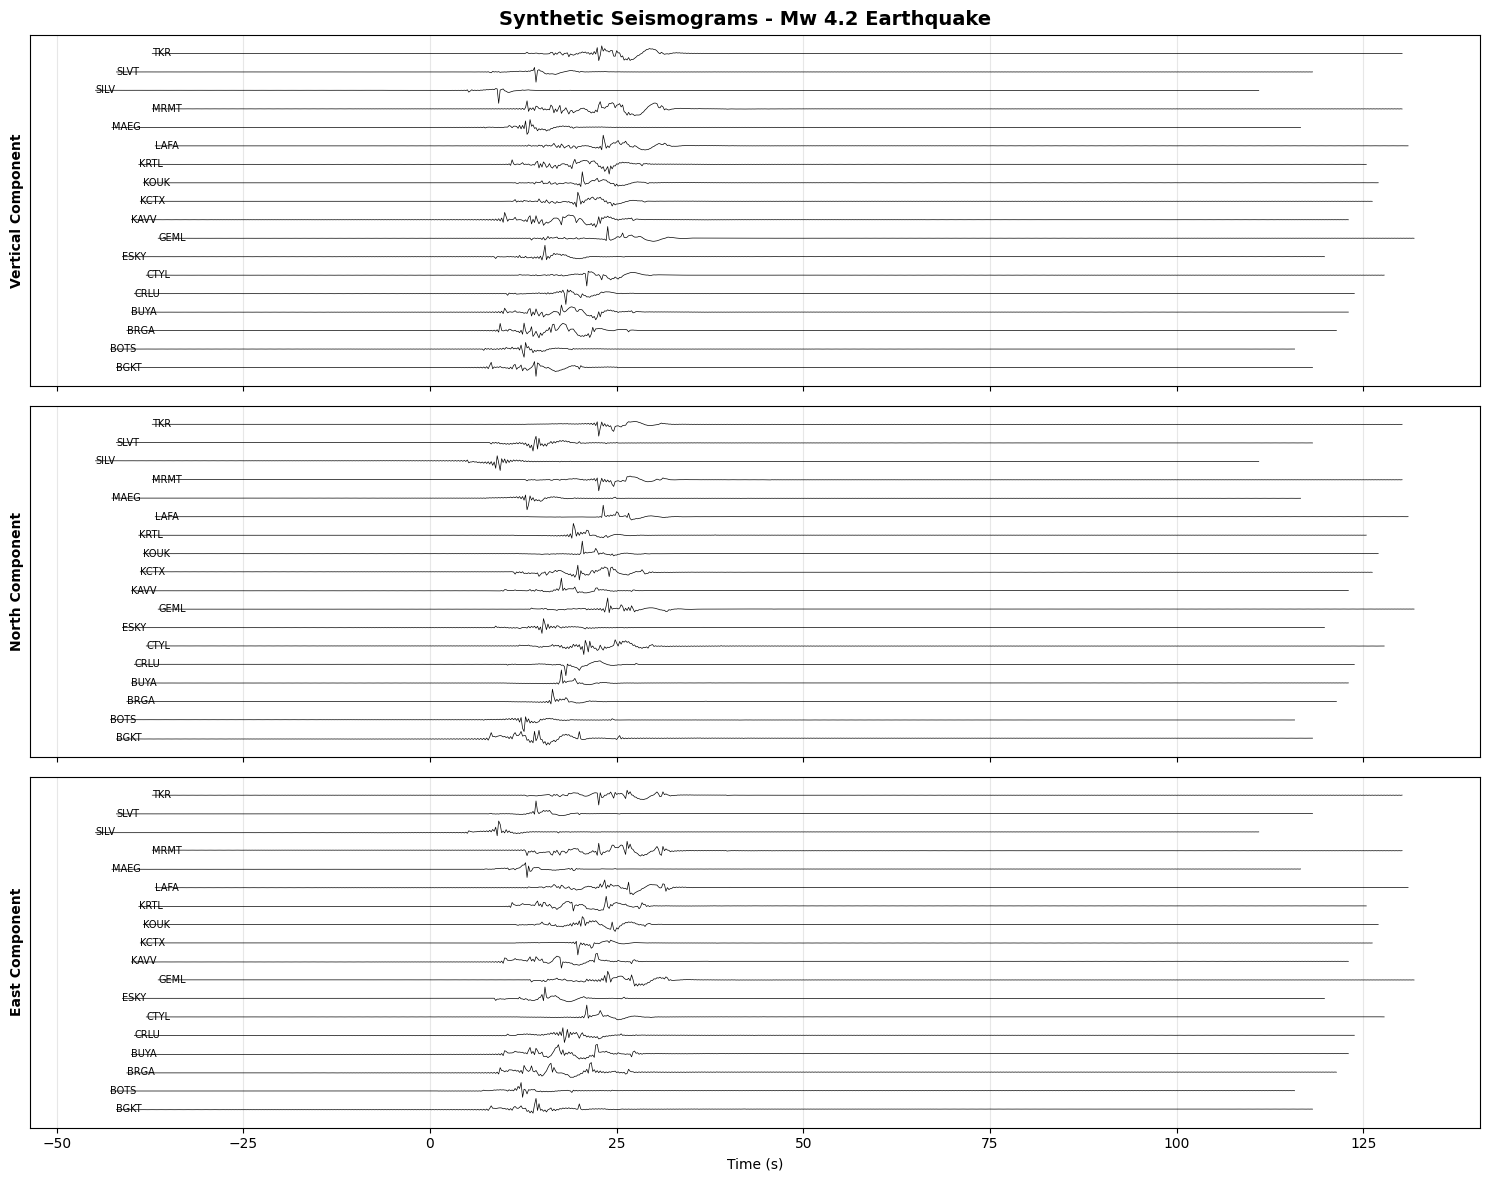

In [134]:
# Plot all traces organized by component
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle(f'Synthetic Seismograms - Mw {source.magnitude} Earthquake', fontsize=14, fontweight='bold')

comp_labels = {'Z': 'Vertical', 'N': 'North', 'E': 'East'}

for i, comp in enumerate(['Z', 'N', 'E']):
    ax = axes[i]
    
    # Filter traces for this component
    comp_traces = [tr for tr in synthetic_traces if tr.channel.endswith(comp)]
    
    # Plot each station with offset
    for j, tr in enumerate(sorted(comp_traces, key=lambda x: x.station)):
        times = tr.get_xdata()
        data = tr.get_ydata()
        
        # Normalize and offset
        if data.max() - data.min() > 0:
            data_norm = (data - data.mean()) / (data.max() - data.min()) * 0.8
        else:
            data_norm = data
        
        ax.plot(times, data_norm + j, 'k-', linewidth=0.5)
        ax.text(times[0], j, f'{tr.station}', fontsize=7, va='center')
    
    ax.set_ylabel(f'{comp_labels[comp]} Component', fontsize=10, fontweight='bold')
    ax.set_ylim(-1, len(comp_traces))
    ax.grid(True, alpha=0.3)
    ax.set_yticks([])

axes[-1].set_xlabel('Time (s)', fontsize=10)
plt.tight_layout()
plt.show()

## 6. Plot Individual Station Examples

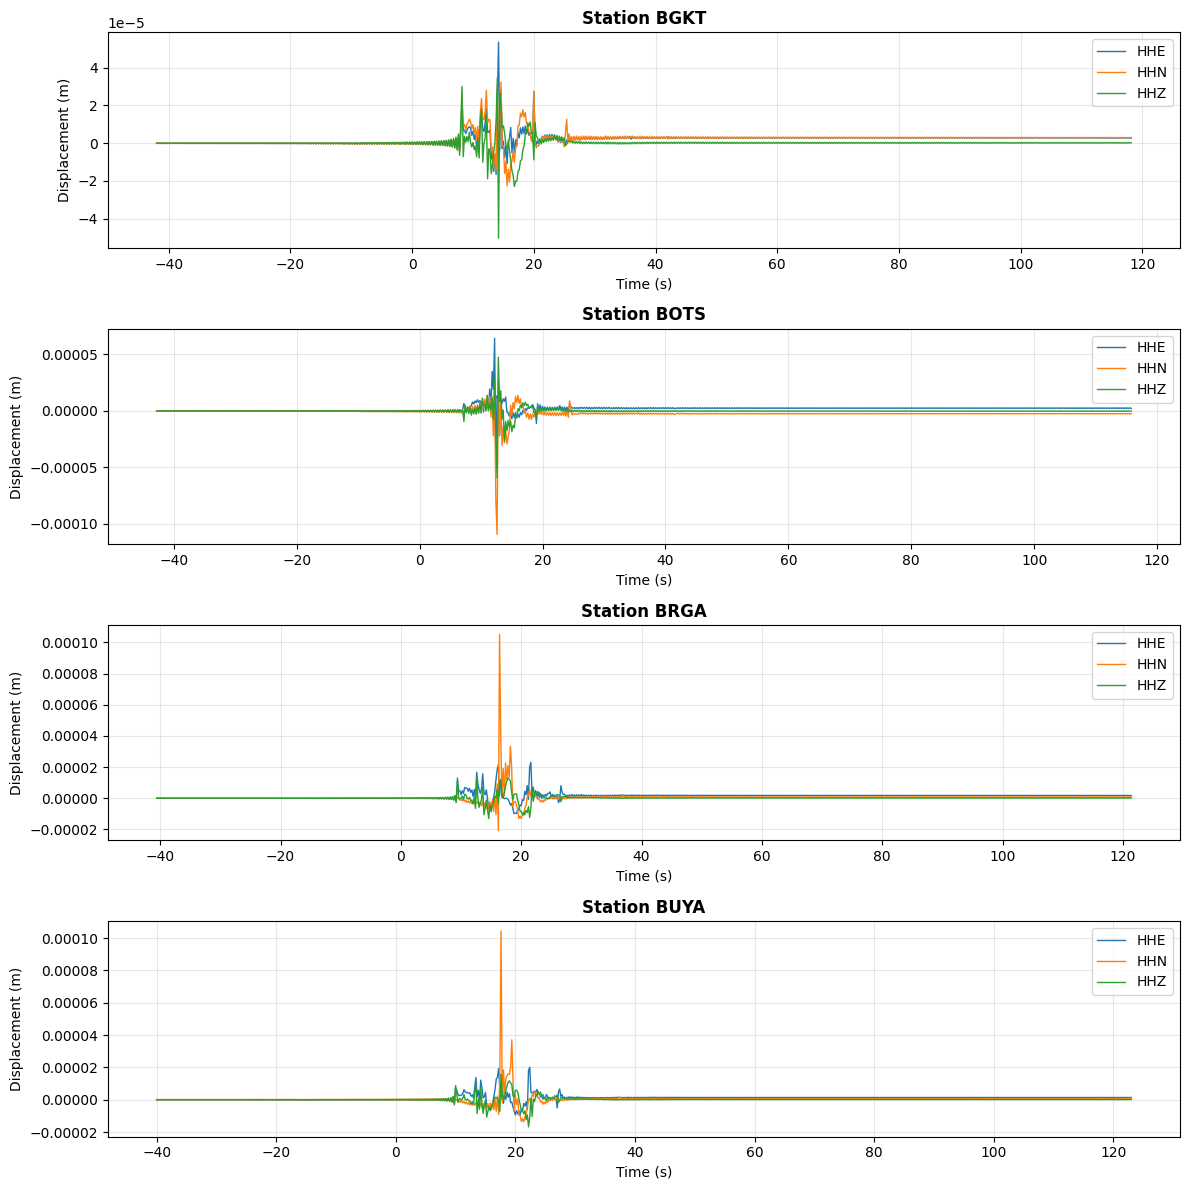

In [135]:
# Select a few stations to plot in detail
example_stations = [st['station'] for st in stations[:4]]  # First 4 stations

fig, axes = plt.subplots(len(example_stations), 1, figsize=(12, 3*len(example_stations)))
if len(example_stations) == 1:
    axes = [axes]

for i, station_code in enumerate(example_stations):
    ax = axes[i]
    
    # Get traces for this station
    station_traces = [tr for tr in synthetic_traces if tr.station == station_code]
    
    for tr in sorted(station_traces, key=lambda x: x.channel):
        times = tr.get_xdata()
        data = tr.get_ydata()
        
        ax.plot(times, data, label=f'{tr.channel}', linewidth=1)
    
    ax.set_title(f'Station {station_code}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement (m)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Compare with Observed Data (Optional)

Loaded 50 observed traces
Event origin time: 2025-04-25T17:33:15.000000Z

Preprocessing observed data...
Preprocessing complete: 50 traces
Applied: trim to 60s, demean, detrend, taper, resample to 20 Hz, lowpass 2 Hz
BGKT.HHN: Obs SR=20.0 Hz, Samples=1198, Duration=59.9s
BGKT.HHE: Obs SR=20.0 Hz, Samples=1200, Duration=60.0s
BOTS.HHZ: Obs SR=20.0 Hz, Samples=1190, Duration=59.5s
BOTS.HHN: Obs SR=20.0 Hz, Samples=1191, Duration=59.6s
BOTS.HHE: Obs SR=20.0 Hz, Samples=1199, Duration=60.0s
BRGA.HHZ: Obs SR=20.0 Hz, Samples=1200, Duration=60.0s
BRGA.HHN: Obs SR=20.0 Hz, Samples=1200, Duration=60.0s
BRGA.HHE: Obs SR=20.0 Hz, Samples=1200, Duration=60.0s


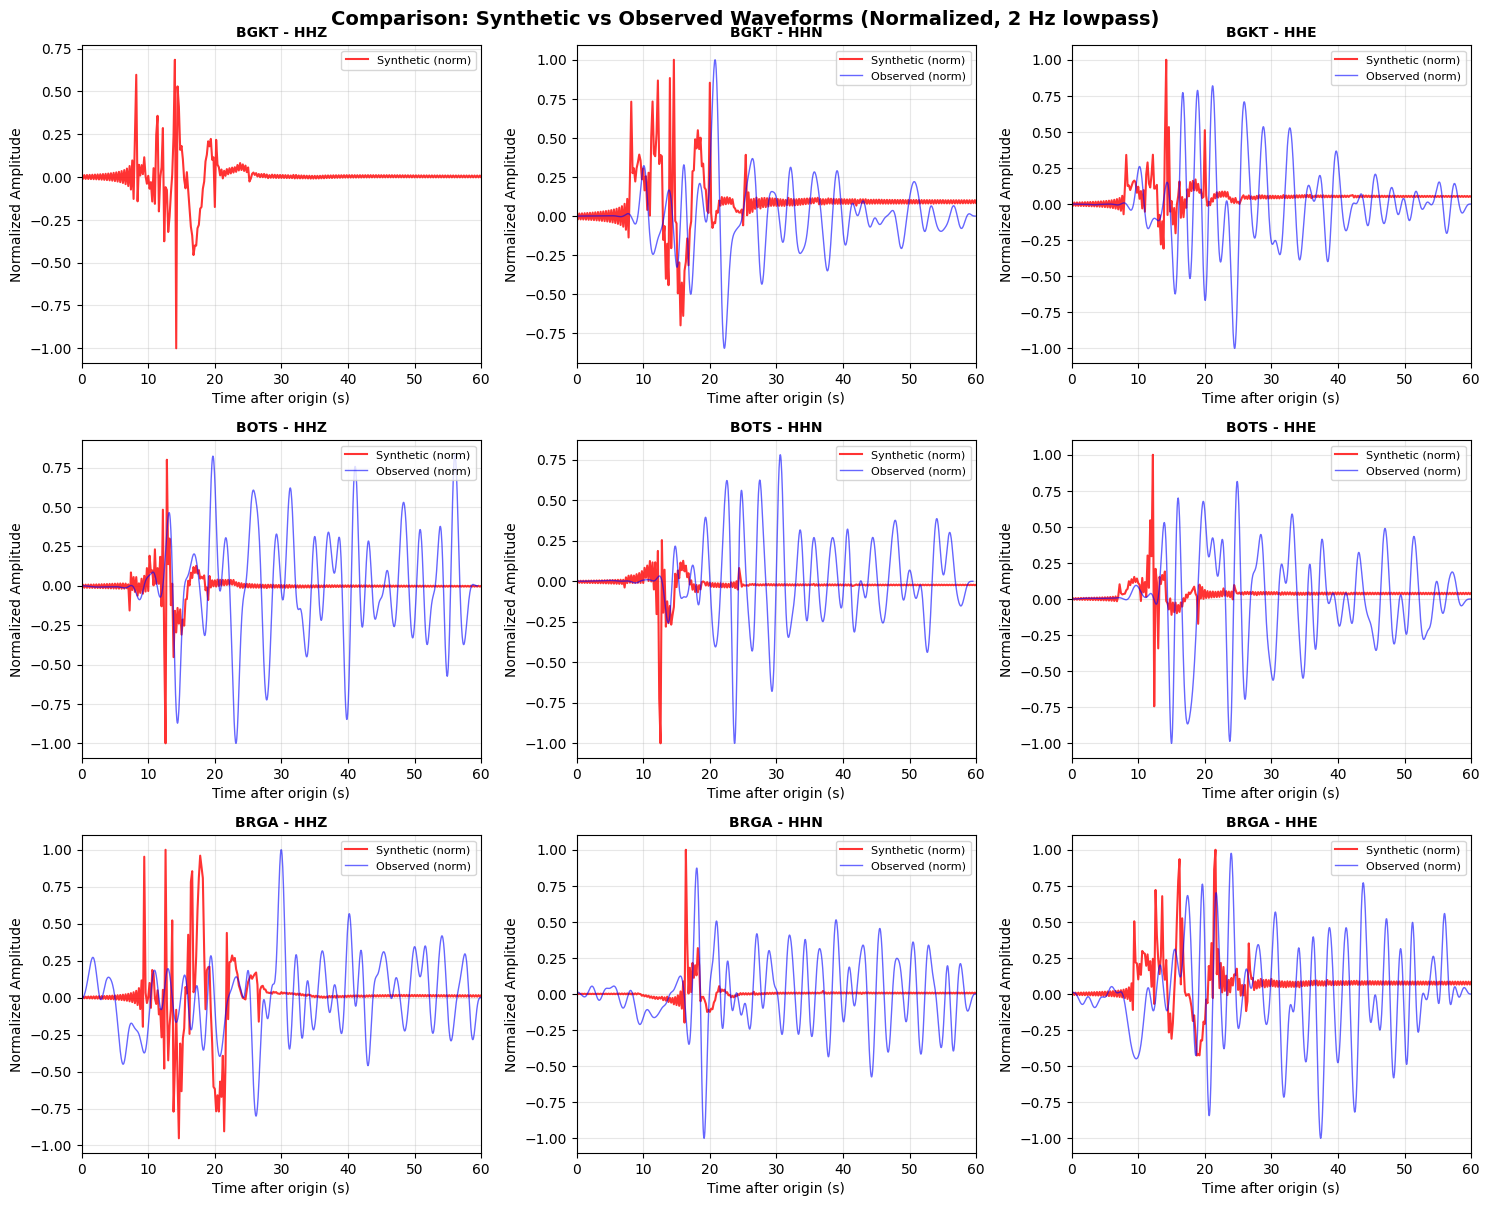


Waveform Comparison Summary:

Station BGKT:
  HHN: Synthetic amp = 3.24e-05 m, Observed amp = 5.28e+04 counts
  HHE: Synthetic amp = 5.36e-05 m, Observed amp = 5.00e+04 counts

Station BOTS:
  HHZ: Synthetic amp = 5.94e-05 m, Observed amp = 7.33e+04 counts
  HHN: Synthetic amp = 1.09e-04 m, Observed amp = 1.12e+05 counts
  HHE: Synthetic amp = 6.43e-05 m, Observed amp = 9.50e+04 counts

Station BRGA:
  HHZ: Synthetic amp = 1.37e-05 m, Observed amp = 1.12e+01 counts
  HHN: Synthetic amp = 1.05e-04 m, Observed amp = 1.77e+01 counts
  HHE: Synthetic amp = 2.31e-05 m, Observed amp = 1.24e+01 counts


In [136]:
# Load observed waveforms from mseed files
from obspy import read, UTCDateTime

waveform_dir = '20250425/waveforms'
mseed_files = [f for f in os.listdir(waveform_dir) if f.endswith('.mseed')]

# Parse the event origin time
event_origin = UTCDateTime(event_time)

# Read all observed traces
observed_traces_raw = []
for mseed_file in sorted(mseed_files):
    try:
        st = read(os.path.join(waveform_dir, mseed_file))
        observed_traces_raw.extend(st)
    except Exception as e:
        print(f"Warning: Could not read {mseed_file}: {e}")

print(f"Loaded {len(observed_traces_raw)} observed traces")
print(f"Event origin time: {event_origin}")

# Preprocess observed data: demean, detrend, taper, and lowpass filter
print("\nPreprocessing observed data...")
observed_traces = []
for tr in observed_traces_raw:
    tr_copy = tr.copy()  # Make a copy to preserve original
    
    # Trim to a reasonable time window (e.g., 60 seconds after event)
    tr_copy = tr_copy.trim(starttime=event_origin, endtime=event_origin + 60)
    
    if len(tr_copy.data) == 0:
        continue
        
    # Check sampling rate and resample if needed
    original_sr = tr_copy.stats.sampling_rate
    target_sr = 20.0  # Resample to 20 Hz for comparison
    
    tr_copy = tr_copy.detrend('demean')  # Remove mean
    tr_copy = tr_copy.detrend('linear')  # Remove linear trend
    tr_copy = tr_copy.taper(max_percentage=0.05, type='cosine')  # Taper endpoints to zero
    
    # Resample if needed
    if abs(original_sr - target_sr) > 0.1:
        tr_copy = tr_copy.resample(target_sr)
        
    tr_copy = tr_copy.filter('lowpass', freq=0.5, corners=4, zerophase=True)  # Lowpass at 2 Hz
    observed_traces.append(tr_copy)

print(f"Preprocessing complete: {len(observed_traces)} traces")
print("Applied: trim to 60s, demean, detrend, taper, resample to 20 Hz, lowpass 2 Hz")

# Select valid stations for comparison
comparison_stations = [st['station'] for st in valid_stations[:3]]  # First 3 valid stations

fig, axes = plt.subplots(len(comparison_stations), 3, figsize=(15, 4*len(comparison_stations)))
if len(comparison_stations) == 1:
    axes = [axes]

for i, station_code in enumerate(comparison_stations):
    for j, comp in enumerate(['Z', 'N', 'E']):
        ax = axes[i][j]
        
        # Get synthetic trace for this station and component
        syn_trace = [tr for tr in synthetic_traces 
                     if tr.station == station_code and tr.channel.endswith(comp)]
        
        # Get observed trace for this station and component
        obs_trace = [tr for tr in observed_traces 
                     if tr.stats.station == station_code and tr.stats.channel.endswith(comp)]
        
        if syn_trace:
            syn_tr = syn_trace[0]
            times_syn = syn_tr.get_xdata()
            data_syn = syn_tr.get_ydata()
            
            # Normalize synthetic
            syn_max = np.max(np.abs(data_syn))
            if syn_max > 0:
                data_syn_norm = data_syn / syn_max
            else:
                data_syn_norm = data_syn
                
            ax.plot(times_syn, data_syn_norm, 'r-', label='Synthetic (norm)', linewidth=1.5, alpha=0.8)
        
        if obs_trace:
            obs_tr = obs_trace[0]
            # Time relative to event origin (seconds)
            times_obs = np.arange(len(obs_tr.data)) * obs_tr.stats.delta
            data_obs = obs_tr.data
            
            # Normalize observed
            obs_max = np.max(np.abs(data_obs))
            if obs_max > 0:
                data_obs_norm = data_obs / obs_max
            else:
                data_obs_norm = data_obs
                
            ax.plot(times_obs, data_obs_norm, 'b-', label='Observed (norm)', linewidth=1, alpha=0.6)
            
            print(f"{station_code}.HH{comp}: Obs SR={obs_tr.stats.sampling_rate:.1f} Hz, "
                  f"Samples={len(obs_tr.data)}, Duration={len(obs_tr.data)*obs_tr.stats.delta:.1f}s")
        
        ax.set_title(f'{station_code} - HH{comp}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Time after origin (s)')
        ax.set_ylabel('Normalized Amplitude')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 60)  # Show first 60 seconds

plt.tight_layout()
plt.suptitle('Comparison: Synthetic vs Observed Waveforms (Normalized, 2 Hz lowpass)', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()

# Calculate basic fit statistics
print("\nWaveform Comparison Summary:")
for station_code in comparison_stations[:3]:
    print(f"\nStation {station_code}:")
    for comp in ['Z', 'N', 'E']:
        syn_trace = [tr for tr in synthetic_traces 
                     if tr.station == station_code and tr.channel.endswith(comp)]
        obs_trace = [tr for tr in observed_traces 
                     if tr.stats.station == station_code and tr.stats.channel.endswith(comp)]
        
        if syn_trace and obs_trace:
            print(f"  HH{comp}: Synthetic amp = {np.max(np.abs(syn_trace[0].get_ydata())):.2e} m, "
                  f"Observed amp = {np.max(np.abs(obs_trace[0].data)):.2e} counts")


## 8. Save Synthetic Traces

In [137]:
# Save synthetic traces to files
output_dir = '20250425/synthetics'
os.makedirs(output_dir, exist_ok=True)

io.save(synthetic_traces, os.path.join(output_dir, 'synthetics.mseed'))
print(f"Saved {len(synthetic_traces)} synthetic traces to {output_dir}/synthetics.mseed")

Saved 54 synthetic traces to 20250425/synthetics/synthetics.mseed
